In [17]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve


# Load training data


In [18]:
df = pd.read_csv("bank-customer-churn-prediction-challenge/train.csv")


# Drop identifiers for EDA


In [19]:
eda_df = df.drop(['id', 'CustomerId', 'Surname'], axis=1)


# One Hot Encoding

In [ ]:
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)

# Select only numeric columns to avoid correlation errors


In [20]:
numeric_df = eda_df.select_dtypes(include='number')


# Heatmap of correlations


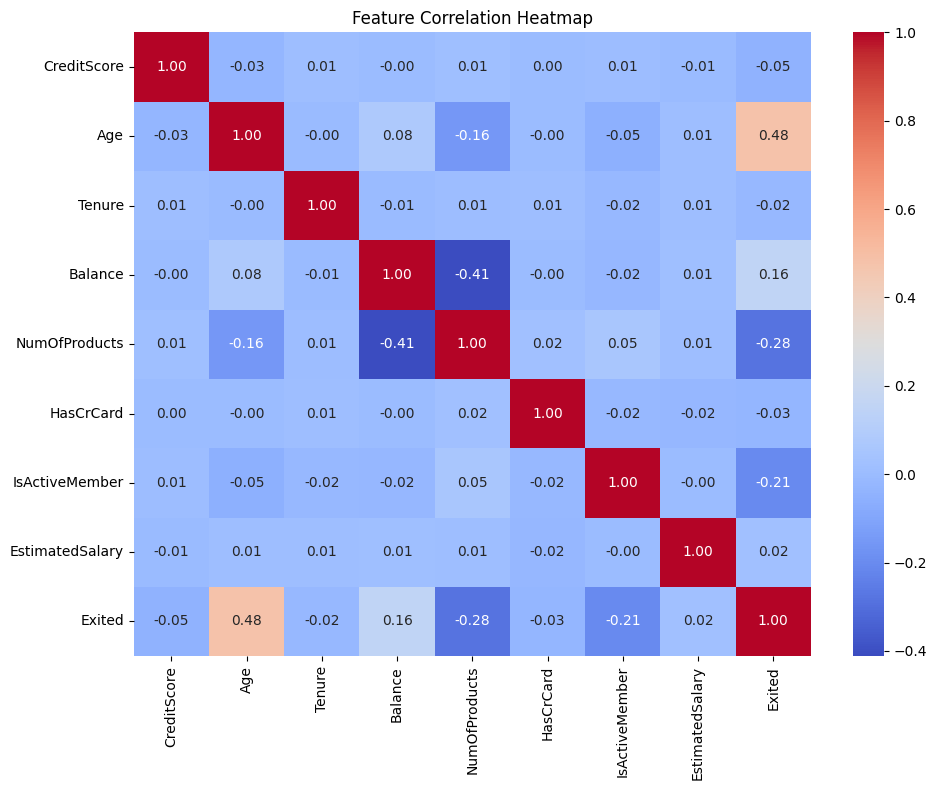

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Boxplot for outlier detection


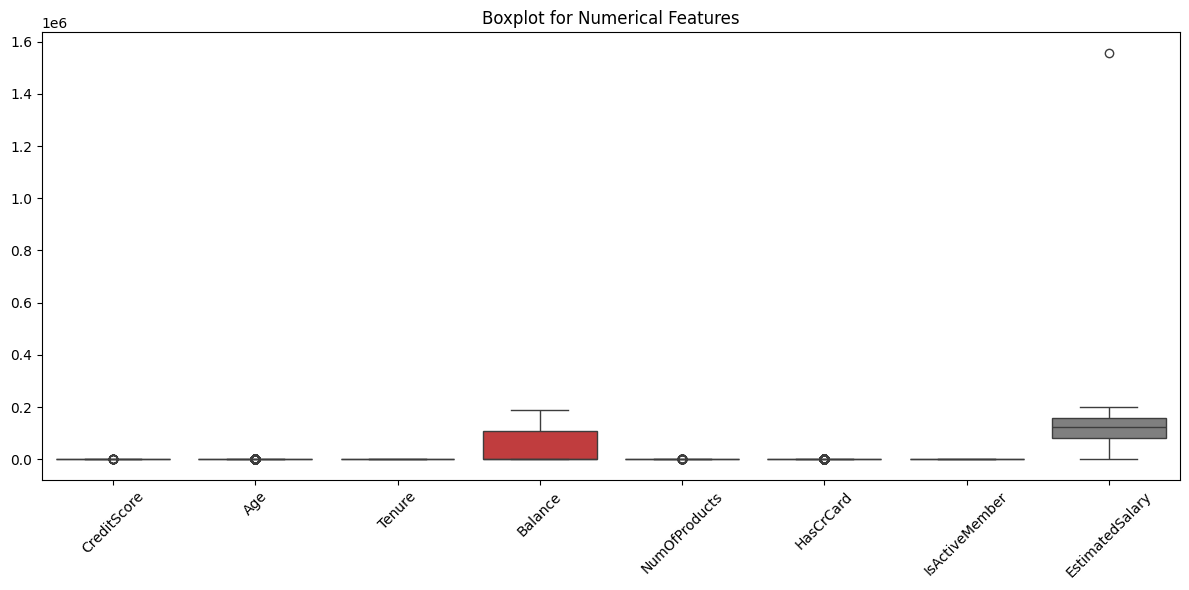

In [22]:

plt.figure(figsize=(12, 6))
sns.boxplot(data=eda_df.drop('Exited', axis=1))
plt.title('Boxplot for Numerical Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Distribution of target variable


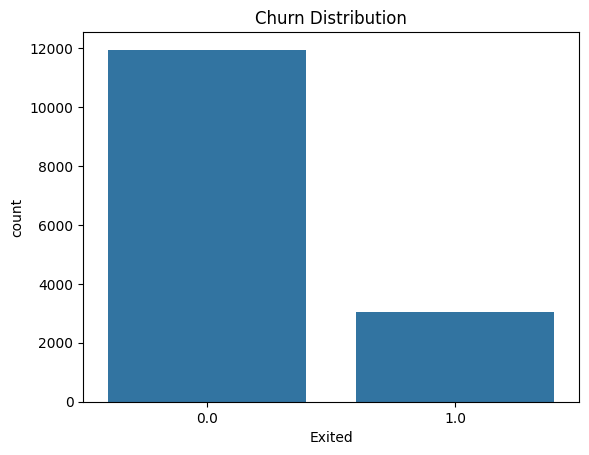

In [23]:
sns.countplot(x='Exited', data=eda_df)
plt.title('Churn Distribution')
plt.show()

# Preprocess function


In [24]:
def preprocess(df):
    df = df.copy()
    for col in ['RowNumber', 'CustomerId', 'Surname']:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)
    df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)
    return df


# Prepare training set


In [25]:
X = preprocess(train_df.drop('Exited', axis=1))
y = train_df['Exited']

# Impute + scale


In [26]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train/test split (optional)

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# Train Logistic Regression model


In [28]:
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

# Save model and preprocessing pipeline


In [29]:


joblib.dump(model, "model_logistic.pkl")
joblib.dump(imputer, "imputer.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(X.columns, "feature_columns.pkl")

print(" Logistic model and preprocessors saved.")


 Logistic model and preprocessors saved.


# Predict on validation set


In [30]:
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)[:, 1]

# Accuracy and F1 Score


In [31]:
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}\n")

Accuracy: 0.8357
F1 Score: 0.6545
ROC AUC: 0.8885



# Classification report


In [32]:
print("Classification Report:")
print(classification_report(y_val, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.85      0.89      2413
         1.0       0.56      0.80      0.65       587

    accuracy                           0.84      3000
   macro avg       0.75      0.82      0.77      3000
weighted avg       0.87      0.84      0.85      3000



# Confusion matrix


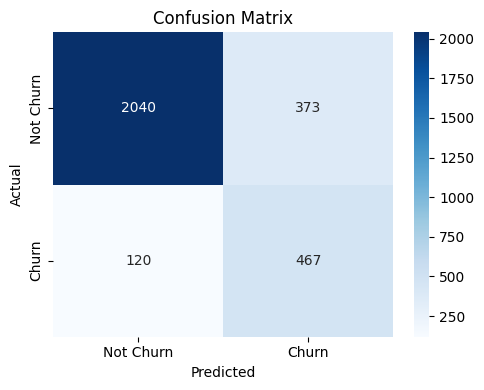

In [33]:
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC Curve


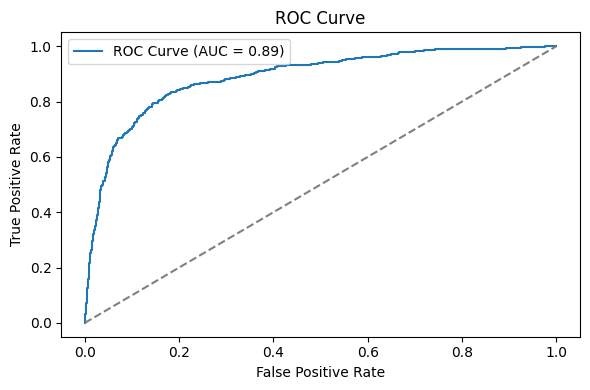

In [34]:

fpr, tpr, _ = roc_curve(y_val, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()


In [35]:
# Load test data
test_df = pd.read_csv("bank-customer-churn-prediction-challenge/test.csv")

# Preprocess
X_test_raw = preprocess(test_df)

# Align columns with training set
feature_columns = joblib.load("feature_columns.pkl")
X_test_raw = X_test_raw.reindex(columns=feature_columns, fill_value=0)

# Apply imputer and scaler
imputer = joblib.load("imputer.pkl")
scaler = joblib.load("scaler.pkl")
X_test_imputed = imputer.transform(X_test_raw)
X_test_scaled = scaler.transform(X_test_imputed)

# Load model and predict probabilities
model = joblib.load("model_logistic.pkl")
probas = model.predict_proba(X_test_scaled)[:, 1]

# Build submission
submission = pd.DataFrame({
    'id': test_df['id'] if 'id' in test_df.columns else test_df['CustomerId'],
    'Exited': probas
})
submission.to_csv("submission.csv", index=False)
